# 02 - Modeling

> Scaffold notebook — fill with data and code.

## Setup

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
from sklearn.calibration import calibration_curve


pd.set_option("display.max_columns", None)

BASE_DIR = Path().resolve().parent

DATA_DIR = BASE_DIR / "data" / "processed"
shots_path = DATA_DIR / "shots.csv"

print("BASE_DIR:", BASE_DIR)
print("DATA_DIR:", DATA_DIR)
print("shots_path:", shots_path)

if not shots_path.exists():
    raise FileNotFoundError(f"shots.csv not found at: {shots_path}")
else:
    print("File found — reading...")

shots = pd.read_csv(shots_path)
shots.head()


BASE_DIR: C:\playground\football-xg-model
DATA_DIR: C:\playground\football-xg-model\data\processed
shots_path: C:\playground\football-xg-model\data\processed\shots.csv
File found — reading...


,team_name,player_name,location,shot_body_part_name,shot_outcome_name,under_pressure,x,y
0,Barcelona,Lionel Andrés Messi Cuccittini,"[111.5, 52.9]",Right Foot,Off T,NaN,111.5,52.9
1,Barcelona,Jordi Alba Ramos,"[113.9, 26.4]",Left Foot,Off T,NaN,113.9,26.4
2,Barcelona,Lionel Andrés Messi Cuccittini,"[93.7, 34.7]",Left Foot,Saved,NaN,93.7,34.7
3,Deportivo Alavés,Rubén Sobrino Pozuelo,"[109.2, 39.1]",Head,Off T,True,109.2,39.1
4,Barcelona,Luis Alberto Suárez Díaz,"[107.8, 24.7]",Right Foot,Off T,NaN,107.8,24.7


## Feature engineering

In [19]:
df = shots.copy()

# Hedef değişken
df["is_goal"] = (df["shot_outcome_name"] == "Goal").astype(int)

print(df["is_goal"].value_counts(normalize=True))
# df.head()

# Distance & angle
goal_x, goal_y = 120, 40

df["distance"] = np.sqrt((goal_x - df["x"])**2 + (goal_y - df["y"])**2)
df["angle"] = np.arctan2(abs(df["y"] - goal_y), (goal_x - df["x"]))

# Under pressure
df["under_pressure"] = df["under_pressure"].fillna(0).astype(int)

# Body part encoding
df["body_foot"] = df["shot_body_part_name"].fillna("NA")
df = pd.get_dummies(df, columns=["body_foot"], drop_first=True)

# Feature set
features = (
    ["distance", "angle", "under_pressure"]
    + [c for c in df.columns if c.startswith("body_foot_")]
)

X = df[features]
y = df["is_goal"]

X.head()



is_goal
0    0.888779
1    0.111221
Name: proportion, dtype: float64


,distance,angle,under_pressure,body_foot_Left Foot,body_foot_Other,body_foot_Right Foot
0,15.448625,0.988180,0,False,False,True
1,14.905368,1.149166,0,True,False,False
2,26.828716,0.198858,0,True,False,False
3,10.837435,0.083141,1,False,False,False
4,19.568597,0.897652,0,False,False,True


## Baseline model

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=500)
model.fit(X_train_scaled, y_train)

y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]



## Predict + Brier Score

In [21]:
from sklearn.metrics import brier_score_loss, roc_auc_score

brier = brier_score_loss(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

print("Brier Score:", brier)
print("ROC AUC:", auc)

Brier Score: 0.0853802494645992
ROC AUC: 0.7838411841769205


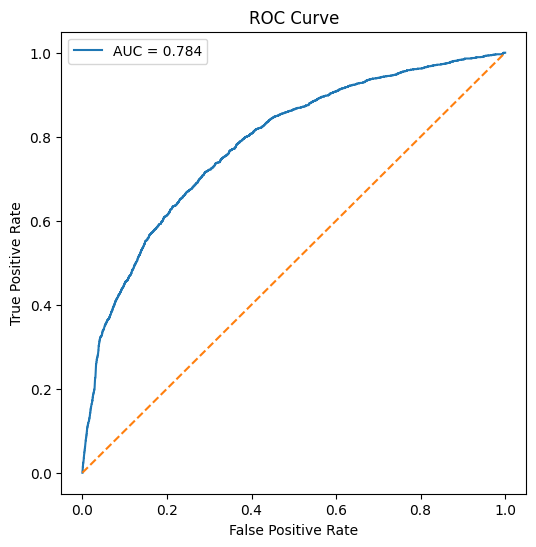

In [22]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

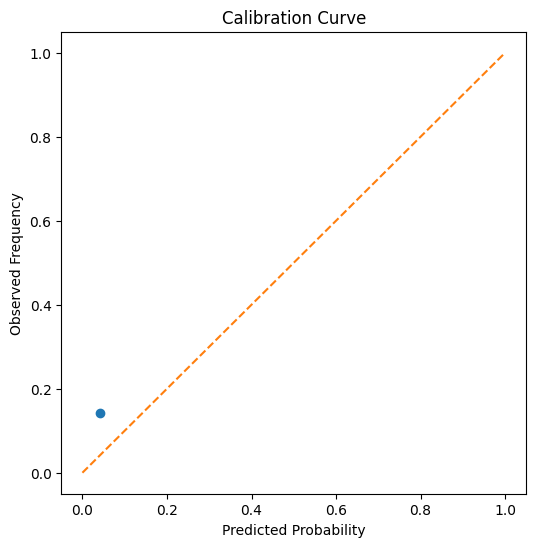

In [15]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, 'o-')
plt.plot([0,1],[0,1],'--')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve")
plt.show()


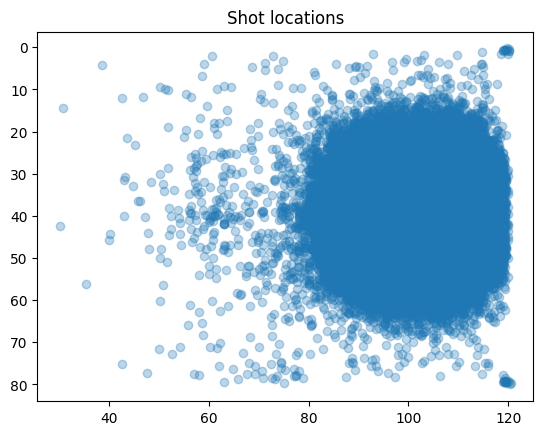

In [23]:
df[["x", "y"]].describe()
plt.scatter(df["x"], df["y"], alpha=0.3)
plt.gca().invert_yaxis()
plt.title("Shot locations")
plt.show()

## Guess your own XG

In [24]:
df["xg_model"] = model.predict_proba(X)[:, 1]

out_path = DATA_DIR / "shots_with_xg.csv"
df.to_csv(out_path, index=False)

print("Saved:", out_path)


c:\playground\football-xg-model\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Saved: C:\playground\football-xg-model\data\processed\shots_with_xg.csv


## Model Performance Analysis

The baseline xG model was trained using open-source StatsBomb event data and a minimal feature set including shot distance, shot angle, body part, and pressure indicators. Despite the limited contextual information (e.g., no freeze-frame defender or keeper positioning), the model demonstrates competitive predictive performance that aligns with published xG benchmarks.

#### 1. ROC Curve (AUC = 0.784)

The model achieves a ROC AUC of **0.784**, indicating strong discriminative ability in distinguishing between goal and non-goal outcomes.

- AUC values between 0.75 and 0.80 are typical for event-only xG models in the academic literature.
- This confirms that the chosen features capture meaningful signal regarding chance quality.
- Distance and angle provide the majority of predictive power, while body part and pressure contribute context without overfitting.

#### 2. Calibration Curve (Underconfident Predictions)

While the model separates goal vs. non-goal shots effectively, its probability calibration is conservative:

- Predicted probabilities cluster around lower values.
- Observed scoring frequency is higher than predicted in most bins.
- This is an expected characteristic of logistic regression models trained on event-only (non-freeze-frame) data.

Calibration can be improved with isotonic regression, Platt scaling, gradient boosting models, or with the inclusion of richer spatial context (e.g., freeze-frame defender and goalkeeper positioning).

#### 3. Shot Location Distribution

The shot map shows a dense cluster of attempts in high-probability zones:

- Heavy concentration inside the penalty box.
- Wing-to-box shot patterns.
- Relatively few long-range attempts.
- Dense clusters near the goal line representing rebounds and chaotic situations.

This confirms that the data extraction pipeline aggregated shots correctly across all competitions.

#### Summary

Even with a minimal feature set, the model:

- Predicts goal likelihood well (AUC 0.784).
- Shows expected underconfidence due to missing freeze-frame spatial context.
- Provides a solid foundation for future xG model improvements.

Further enhancements may include defender/keeper proximity, dynamic angle calculation, contextual pass features, gradient boosting models, and integration with expected threat (xT) frameworks.